# 用户行为序列分析&用户画像

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns

In [10]:
# 读取数据
file_path = 'UserBehavior.csv'  # 修改为你的数据路径
column_names = ['user_id', 'item_id', 'category_id', 'behavior_type', 'timestamp']
df = pd.read_csv(file_path, names=column_names)


In [11]:
# 时间戳转换为 datetime
df['event_time'] = pd.to_datetime(df['timestamp'], unit='s')
df['date'] = df['event_time'].dt.date
df['hour'] = df['event_time'].dt.hour
df['weekday'] = df['event_time'].dt.day_name()  # 后面可用于分析周几


In [12]:
# 数据按时间过滤 保留2017年11月25日至2017年12月3日之间
start_date = pd.to_datetime('2017-11-25')
end_date = pd.to_datetime('2017-12-03 23:59:59') 
# 过滤数据
df = df[(df['event_time'] >= start_date) & (df['event_time'] <= end_date)]

In [13]:
# 行为类型标准顺序
behavior_order = ['pv', 'cart', 'fav', 'buy']
df['behavior_type'] = pd.Categorical(df['behavior_type'], categories=behavior_order, ordered=True)

In [14]:
# 查看数据概况
print(df.head(100))
print(df['behavior_type'].value_counts())

     user_id  item_id  category_id behavior_type   timestamp  \
2          1  2576651       149192            pv  1511572885   
3          1  3830808      4181361            pv  1511593493   
4          1  4365585      2520377            pv  1511596146   
5          1  4606018      2735466            pv  1511616481   
6          1   230380       411153            pv  1511644942   
..       ...      ...          ...           ...         ...   
112      100  4863356      2293367            pv  1511766426   
113      100  4244099      2293367            pv  1511766434   
114      100   562760      2293367            pv  1511766436   
115      100  4863356      2293367            pv  1511766455   
116      100  1640913      2293367            pv  1511766462   

             event_time        date  hour   weekday  
2   2017-11-25 01:21:25  2017-11-25     1  Saturday  
3   2017-11-25 07:04:53  2017-11-25     7  Saturday  
4   2017-11-25 07:49:06  2017-11-25     7  Saturday  
5   2017-11-25 

## 1.用户行为序列分析

### 1.1 漏斗模型 以用户数为单位

In [15]:
# 构建每种行为的用户集合
pv_users   = set(df[df['behavior_type'] == 'pv']['user_id'].unique())
cart_users = set(df[df['behavior_type'] == 'cart']['user_id'].unique())
fav_users  = set(df[df['behavior_type'] == 'fav']['user_id'].unique())
buy_users  = set(df[df['behavior_type'] == 'buy']['user_id'].unique())


In [16]:
print("浏览用户数量：", len(pv_users), "示例用户ID：", list(pv_users)[:10])
print("加购用户数量：", len(cart_users), "示例用户ID：", list(cart_users)[:10])
print("收藏用户数量：", len(fav_users), "示例用户ID：", list(fav_users)[:10])
print("购买用户数量：", len(buy_users), "示例用户ID：", list(buy_users)[:10])


浏览用户数量： 984080 示例用户ID： [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
加购用户数量： 737393 示例用户ID： [2, 3, 4, 6, 7, 8, 9, 11, 13, 14]
收藏用户数量： 388261 示例用户ID： [2, 3, 6, 7, 10, 11, 16, 18, 21, 23]
购买用户数量： 670370 示例用户ID： [2, 4, 11, 16, 17, 20, 24, 25, 27, 28]


In [17]:
# 统计每一步漏斗中仍然保留的用户数
step1 = pv_users
step2 = pv_users & cart_users   # 浏览且加购
step3 = step2 & fav_users       # 浏览+加购+收藏
step4 = step3 & buy_users       # 浏览+加购+收藏+购买

In [18]:
# 每个阶段的用户数
funnel_counts = {
    '浏览(pv)': len(step1),
    '加购(cart)': len(step2),
    '收藏(fav)': len(step3),
    '购买(buy)': len(step4)
}

# 计算转化率（相对于起点）
funnel_df = pd.DataFrame({
    '阶段': list(funnel_counts.keys()),
    '用户数': list(funnel_counts.values())
})
funnel_df['转化率'] = funnel_df['用户数'] / funnel_df['用户数'].iloc[0]



In [19]:
funnel_df

,阶段,用户数,转化率
0,浏览(pv),984080,1.000000
1,加购(cart),734059,0.745934
2,收藏(fav),265976,0.270279
3,购买(buy),201855,0.205121


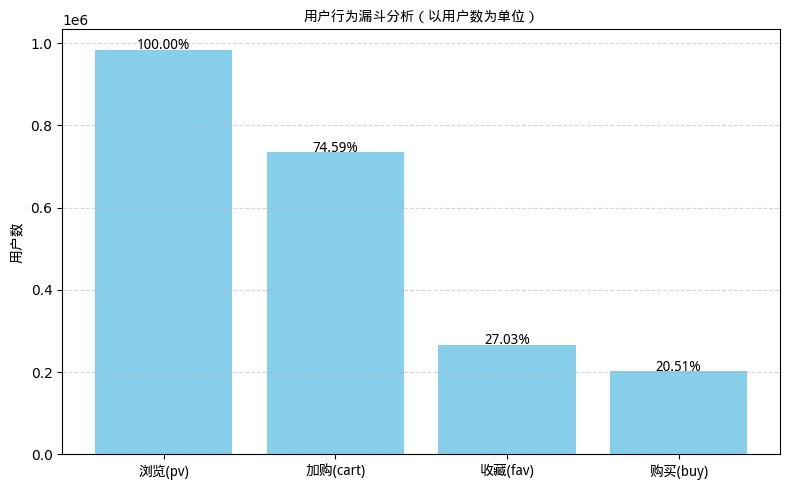

In [20]:
from matplotlib import pyplot as plt
from matplotlib import font_manager

# 1) 指定字体文件路径
font_path = '/usr/share/fonts/truetype/wqy/wqy-microhei.ttc'
myfont = font_manager.FontProperties(fname=font_path)

# 2) 漏斗图示例
plt.figure(figsize=(8,5))
plt.bar(funnel_df['阶段'], funnel_df['用户数'], color='skyblue')

# 3) 给中文标题、坐标轴标签、x轴刻度及文字标签都指定字体
plt.title('用户行为漏斗分析（以用户数为单位）', fontproperties=myfont)
plt.ylabel('用户数', fontproperties=myfont)
plt.xticks(fontproperties=myfont)  # x轴刻度标签字体

for i, (cnt, rate) in enumerate(zip(funnel_df['用户数'], funnel_df['转化率'])):
    plt.text(i, cnt + 2000, f'{rate:.2%}', ha='center', fontsize=10, fontproperties=myfont)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('figures/用户行为漏斗分析.png')
plt.show()


从浏览到加购，转化率较高（74.6%），说明产品或页面对用户有一定吸引力，且购物流程设计较合理。

从加购到收藏，转化率明显降低（27.0%），这可能反映出用户对部分商品还未完全决策，收藏用作“后续考虑”。

从收藏到购买的转化率进一步降低（20.5%），说明从兴趣转变为实际购买的门槛较高，可能涉及价格、支付、信任等多方面因素。

提高加购阶段转化率：针对浏览到加购，虽然比例不错，但仍有约25%流失，可优化商品推荐、优惠活动吸引力。

促进收藏用户转化：加强收藏提醒、促销推送，缩短从兴趣到购买的时间间隔。

购买转化提升：简化支付流程，增强用户信任，提升购买转化率。



### 1.2 漏斗细分

In [21]:
# 按天统计漏斗每阶段用户数，计算转化率趋势

#  每天每种行为的用户数（去重）
daily_users = (
    df.groupby(['date', 'behavior_type'])['user_id']
    .nunique()
    .unstack(fill_value=0)
    .rename(columns={'pv': '浏览', 'cart': '加购', 'fav': '收藏', 'buy': '购买'})
)

In [22]:
daily_users

behavior_type,浏览,加购,收藏,购买
date,,,,
2017-11-25,685907,238423,115624,132682
2017-11-26,693559,244564,116796,139992
2017-11-27,688495,234480,113588,143224
2017-11-28,687244,233545,114000,139820
2017-11-29,698074,240395,116477,146513
2017-11-30,709828,245777,118035,146370
2017-12-01,731566,266994,121845,141928
2017-12-02,913314,330388,151471,174698
2017-12-03,886400,297577,135405,160607


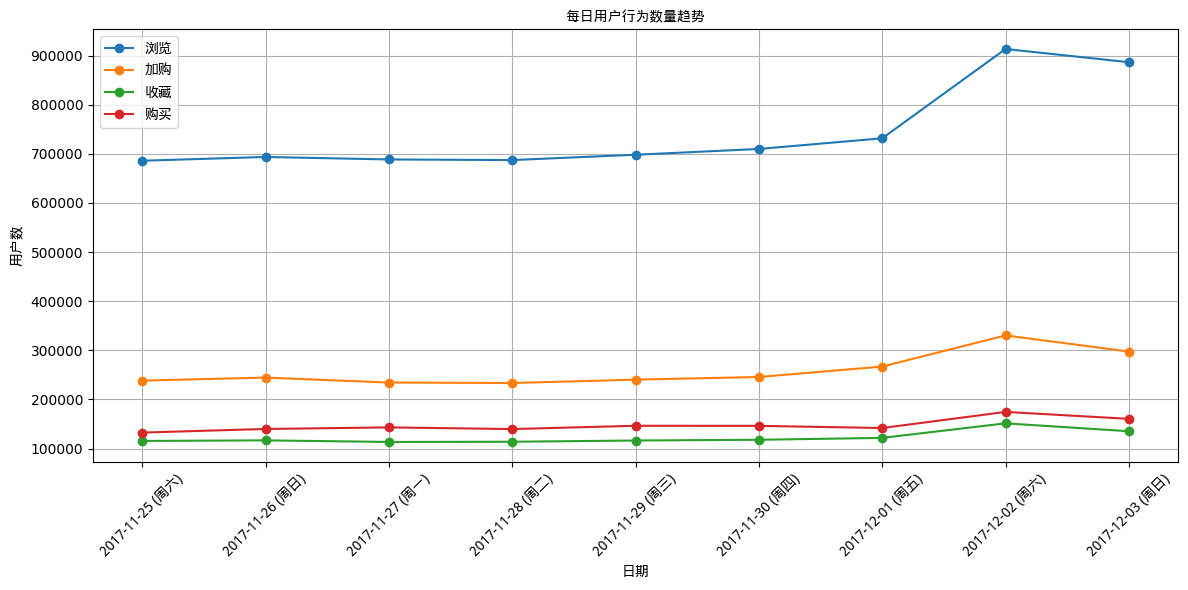

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# 确保 daily_users.index 是 datetime 类型
dates = pd.to_datetime(daily_users.index)

# 生成日期 + 星期几标签，如 '2023-07-23 (周三)'

weekday_map = {0:'周一',1:'周二',2:'周三',3:'周四',4:'周五',5:'周六',6:'周日'}
date_labels = dates.strftime('%Y-%m-%d') + ' (' + dates.weekday.map(weekday_map) + ')'

plt.figure(figsize=(12, 6))

behavior_cols = ['浏览', '加购', '收藏', '购买']

for col in behavior_cols:
    plt.plot(dates, daily_users[col], marker='o', label=col)

plt.title('每日用户行为数量趋势', fontproperties=myfont)
plt.xlabel('日期', fontproperties=myfont)
plt.ylabel('用户数', fontproperties=myfont)

# 设置自定义x轴标签
plt.xticks(ticks=dates, labels=date_labels, rotation=45,fontproperties=myfont)

plt.grid(True)
plt.legend(prop=myfont)
plt.tight_layout()
plt.savefig('figures/每日用户行为数量趋势.png')
plt.show()


In [24]:
#  计算转化率（避免除0）
daily_users['浏览→加购'] = daily_users['加购'] / daily_users['浏览'].replace(0, pd.NA)
daily_users['浏览→购买'] = daily_users['购买'] / daily_users['浏览'].replace(0, pd.NA)
daily_users['加购→购买'] = daily_users['购买'] / daily_users['加购'].replace(0, pd.NA)
daily_users['浏览→收藏'] = daily_users['收藏'] / daily_users['浏览'].replace(0, pd.NA)
daily_users['收藏→购买'] = daily_users['购买'] / daily_users['收藏'].replace(0, pd.NA)


In [25]:
daily_users

behavior_type,浏览,加购,收藏,购买,浏览→加购,浏览→购买,加购→购买,浏览→收藏,收藏→购买
date,,,,,,,,,
2017-11-25,685907,238423,115624,132682,0.347603,0.193440,0.556498,0.168571,1.147530
2017-11-26,693559,244564,116796,139992,0.352622,0.201846,0.572415,0.168401,1.198603
2017-11-27,688495,234480,113588,143224,0.340569,0.208025,0.610815,0.164980,1.260908
2017-11-28,687244,233545,114000,139820,0.339828,0.203450,0.598685,0.165880,1.226491
2017-11-29,698074,240395,116477,146513,0.344369,0.209882,0.609468,0.166855,1.257871
2017-11-30,709828,245777,118035,146370,0.346249,0.206205,0.595540,0.166287,1.240056
2017-12-01,731566,266994,121845,141928,0.364962,0.194006,0.531577,0.166554,1.164824
2017-12-02,913314,330388,151471,174698,0.361746,0.191279,0.528766,0.165848,1.153343
2017-12-03,886400,297577,135405,160607,0.335714,0.181190,0.539716,0.152758,1.186123


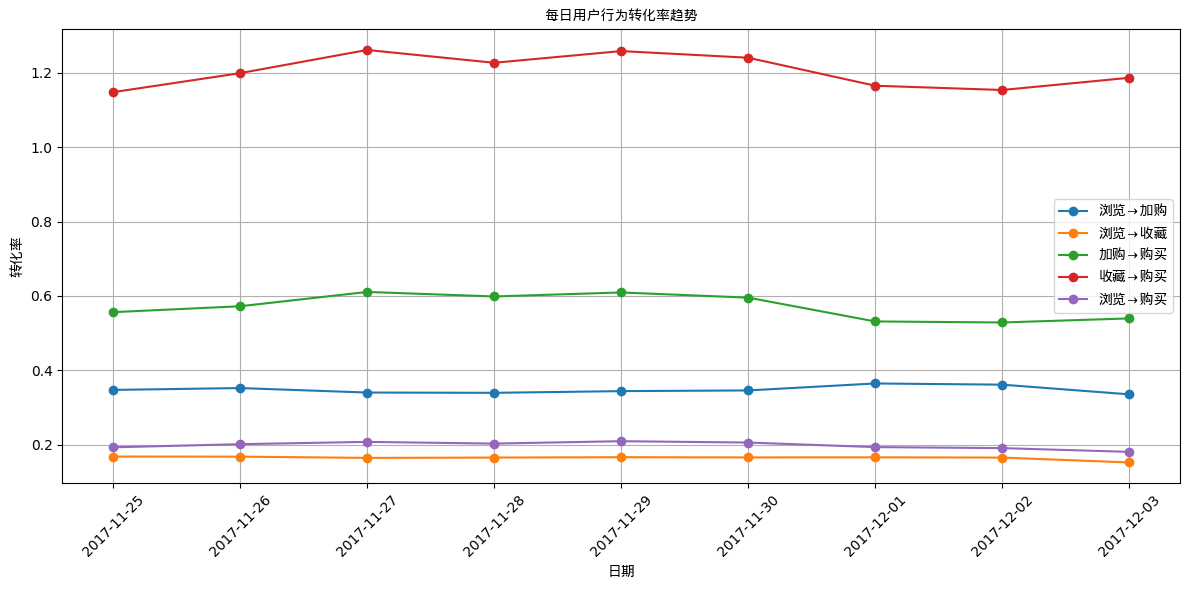

In [26]:
plt.figure(figsize=(12, 6))

# 要绘制的转化路径列
conversion_paths = ['浏览→加购', '浏览→收藏', '加购→购买', '收藏→购买', '浏览→购买']

# 遍历每个转化路径，绘制线条
for col in conversion_paths:
    plt.plot(daily_users.index, daily_users[col], marker='o', label=col)

# 设置图表信息
plt.title('每日用户行为转化率趋势',fontproperties=myfont)
plt.xlabel('日期',fontproperties=myfont)
plt.ylabel('转化率',fontproperties=myfont)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(prop=myfont)
plt.tight_layout()
plt.savefig('figures/每日用户行为转化率趋势.png')
plt.show()

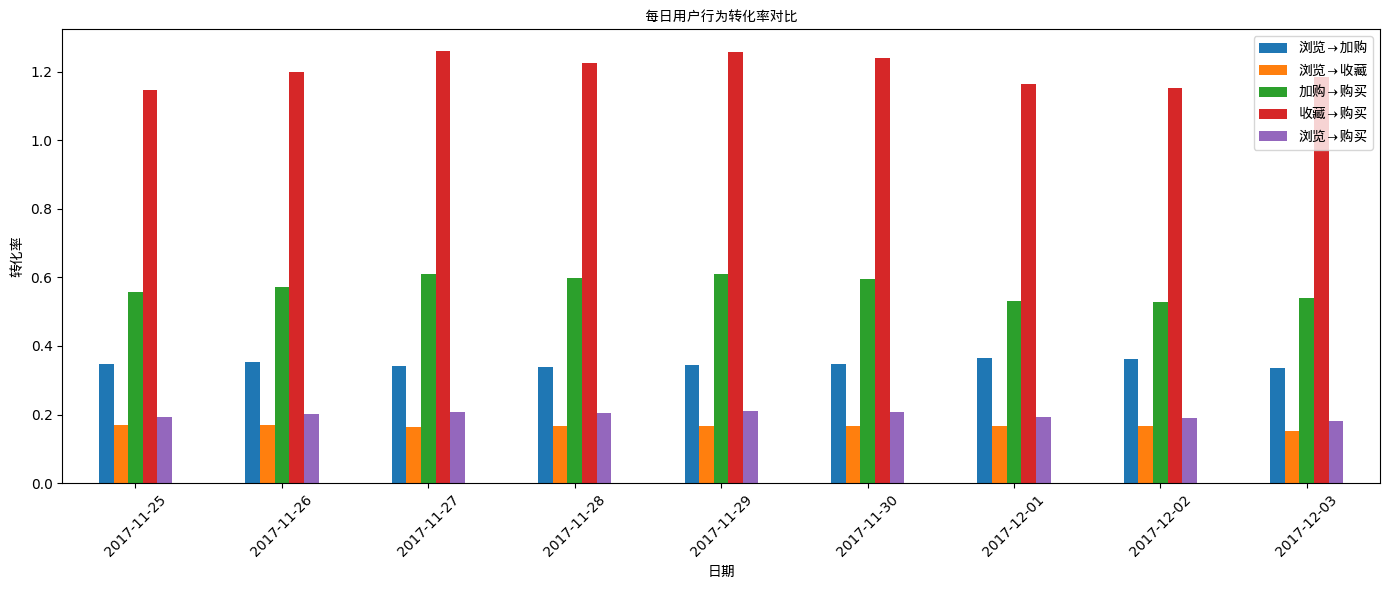

In [27]:
daily_users[conversion_paths].plot(kind='bar', figsize=(14, 6))
plt.title('每日用户行为转化率对比', fontproperties=myfont)
plt.xlabel('日期', fontproperties=myfont)
plt.ylabel('转化率', fontproperties=myfont)
plt.xticks(rotation=45)
plt.legend(prop=myfont)
plt.tight_layout()
plt.savefig('figures/每日用户行为转化率对比.png')
plt.show()


浏览→加购稳定：说明商品整体吸引力尚可，用户有一定兴趣。

加购→购买比例偏高：大多数加购用户倾向于最终购买，是重点转化对象。

浏览→购买略下降（12月初）：可能因活动结束或用户决策周期拉长。

收藏→购买 >1 说明收藏行为与购买行为时间存在错位或用户群不一致，不能直接解读为收藏必然转化。

12月1日-3日活跃度上升：特别是 12月2日，行为数显著增长，可能与促销或活动有关。

In [28]:
#漏斗阻断分析
mean_conv = daily_users[['浏览→加购', '浏览→收藏', '浏览→购买', '加购→购买', '收藏→购买']].mean()
mean_conv.sort_values()

behavior_type
浏览→收藏    0.165126
浏览→购买    0.198814
浏览→加购    0.348185
加购→购买    0.571498
收藏→购买    1.203972
dtype: float64

In [29]:
# 基于商品类目进行细分
# 行为类型映射中文
behavior_map = {'pv': '浏览', 'cart': '加购', 'fav': '收藏', 'buy': '购买'}

# 添加日期字段
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df['date'] = df['datetime'].dt.date

# 替换行为中文
df['行为'] = df['behavior_type'].map(behavior_map)

In [30]:
# 统计每类目每天各阶段的用户数
daily_cat_users = (
    df.groupby(['date', 'category_id', '行为'])['user_id']
    .nunique()
    .unstack(fill_value=0)
    .reset_index()
)

In [31]:
# 为避免 KeyError，确保缺失行为的列也在
for col in ['浏览', '加购', '收藏', '购买']:
    if col not in daily_cat_users.columns:
        daily_cat_users[col] = 0

# 计算转化率（用户数为单位）
daily_cat_users['浏览→加购'] = daily_cat_users['加购'] / daily_cat_users['浏览'].replace(0, np.nan)
daily_cat_users['浏览→收藏'] = daily_cat_users['收藏'] / daily_cat_users['浏览'].replace(0, np.nan)
daily_cat_users['浏览→购买'] = daily_cat_users['购买'] / daily_cat_users['浏览'].replace(0, np.nan)
daily_cat_users['加购→购买'] = daily_cat_users['购买'] / daily_cat_users['加购'].replace(0, np.nan)
daily_cat_users['收藏→购买'] = daily_cat_users['购买'] / daily_cat_users['收藏'].replace(0, np.nan)


In [32]:
daily_cat_users

行为,date,category_id,浏览,加购,收藏,购买,浏览→加购,浏览→收藏,浏览→购买,加购→购买,收藏→购买
0,2017-11-25,80,2,0,0,0,0.000000,0.000000,0.000000,NaN,NaN
1,2017-11-25,1147,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2,2017-11-25,2171,73,9,5,5,0.123288,0.068493,0.068493,0.555556,1.0
3,2017-11-25,2410,45,4,1,2,0.088889,0.022222,0.044444,0.500000,2.0
4,2017-11-25,2424,1,0,0,0,0.000000,0.000000,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
84910,2017-12-03,5159111,0,0,0,0,NaN,NaN,NaN,NaN,NaN
84911,2017-12-03,5159987,2,0,0,0,0.000000,0.000000,0.000000,NaN,NaN
84912,2017-12-03,5160054,6,1,0,1,0.166667,0.000000,0.166667,1.000000,NaN
84913,2017-12-03,5161669,80,17,2,24,0.212500,0.025000,0.300000,1.411765,12.0


In [33]:
# 选出浏览最多的前3个类目
top_cats = (
    df[df['behavior_type'] == 'pv']
    .groupby('category_id')['user_id'].nunique()
    .nlargest(3)
    .index.tolist()
)

In [34]:
top_cats

[4756105, 982926, 4145813]

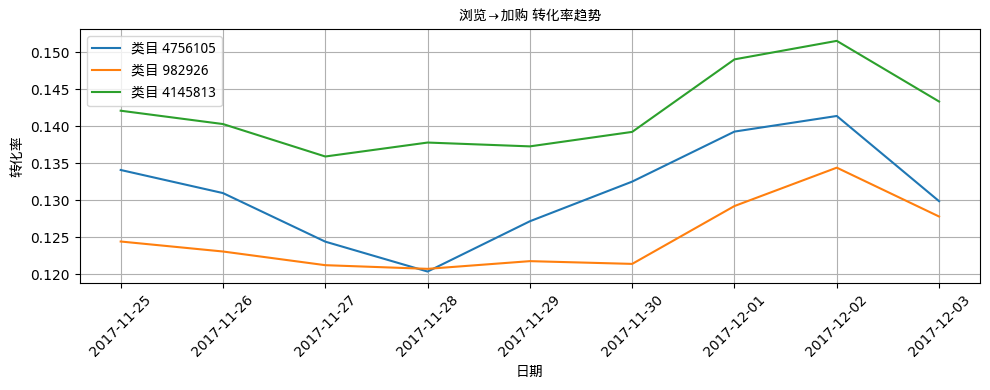

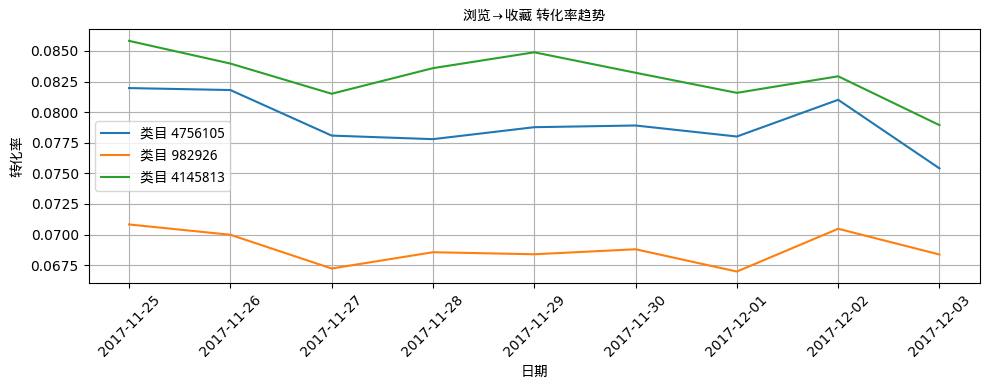

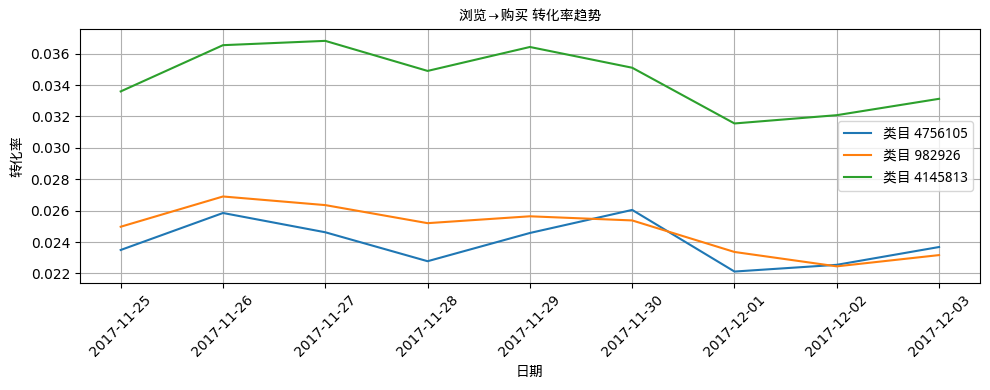

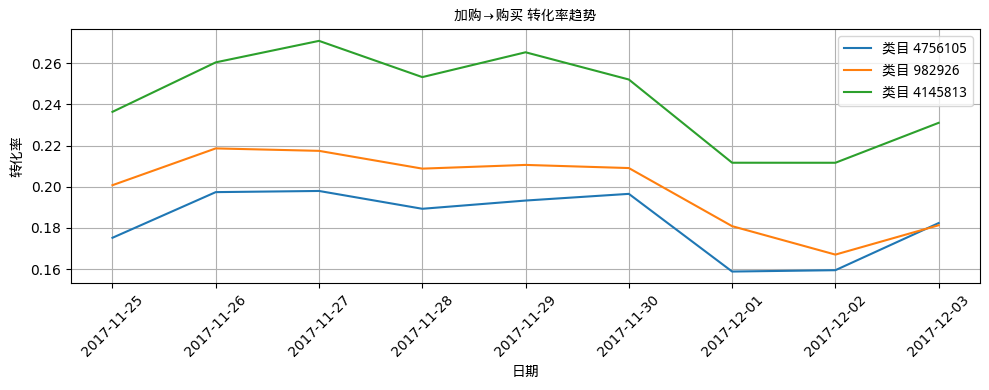

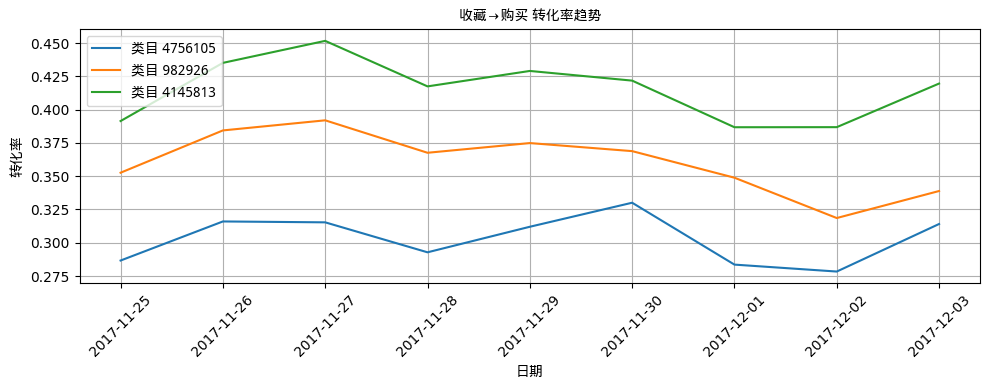

行为           date  category_id      浏览     加购     收藏    购买     浏览→加购  \
8686   2017-11-25      4756105  119989  16089   9835  2819  0.134087   
18121  2017-11-26      4756105  116288  15229   9513  3006  0.130959   
27556  2017-11-27      4756105  109010  13559   8512  2684  0.124383   
36991  2017-11-28      4756105  105406  12684   8200  2401  0.120335   
46426  2017-11-29      4756105  109088  13870   8593  2681  0.127145   
55861  2017-11-30      4756105  113535  15045   8959  2957  0.132514   
65296  2017-12-01      4756105  121562  16932   9483  2689  0.139287   
74731  2017-12-02      4756105  145862  20625  11816  3289  0.141401   
84166  2017-12-03      4756105  131993  17141   9953  3126  0.129863   

行为        浏览→收藏     浏览→购买     加购→购买     收藏→购买  
8686   0.081966  0.023494  0.175213  0.286629  
18121  0.081806  0.025850  0.197387  0.315989  
27556  0.078085  0.024622  0.197950  0.315320  
36991  0.077794  0.022779  0.189294  0.292805  
46426  0.078771  0.024576  0.193295  0.

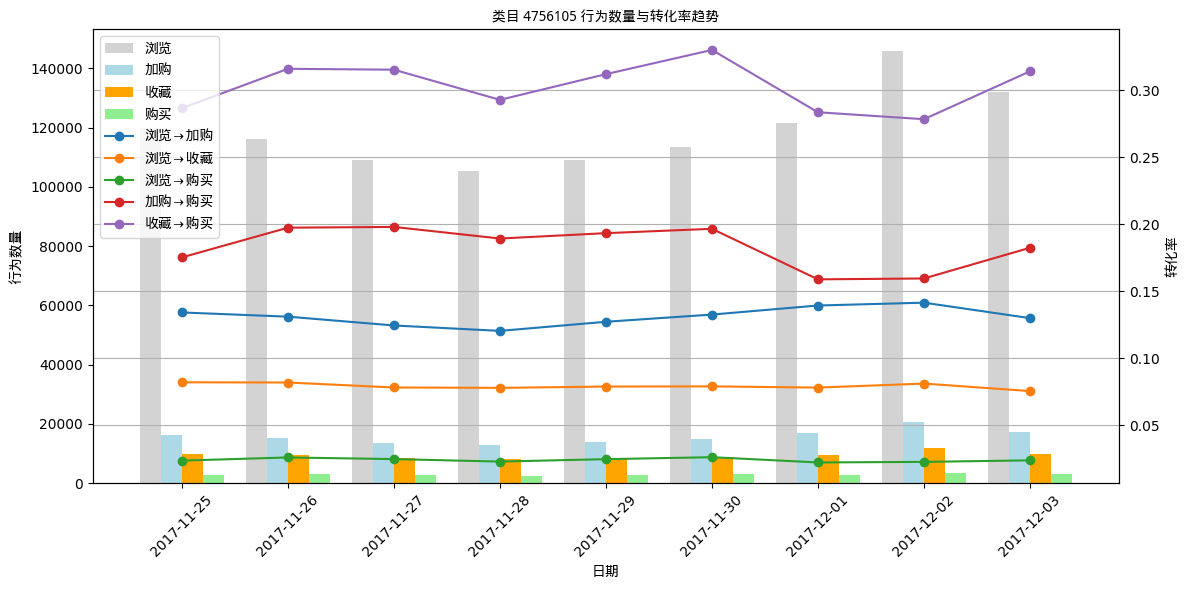

行为           date  category_id      浏览     加购    收藏    购买     浏览→加购     浏览→收藏  \
1783   2017-11-25       982926  100344  12483  7107  2506  0.124402  0.070826   
11218  2017-11-26       982926   98807  12158  6915  2658  0.123048  0.069985   
20653  2017-11-27       982926   93427  11323  6281  2462  0.121196  0.067229   
30088  2017-11-28       982926   92096  11116  6314  2321  0.120700  0.068559   
39523  2017-11-29       982926   92671  11282  6338  2376  0.121743  0.068392   
48958  2017-11-30       982926   95682  11613  6583  2428  0.121371  0.068801   
58393  2017-12-01       982926  100312  12961  6719  2344  0.129207  0.066981   
67828  2017-12-02       982926  119730  16092  8438  2688  0.134402  0.070475   
77263  2017-12-03       982926  109418  13982  7481  2535  0.127785  0.068371   

行为        浏览→购买     加购→购买     收藏→购买  
1783   0.024974  0.200753  0.352610  
11218  0.026901  0.218621  0.384382  
20653  0.026352  0.217434  0.391976  
30088  0.025202  0.208798  0.367596  

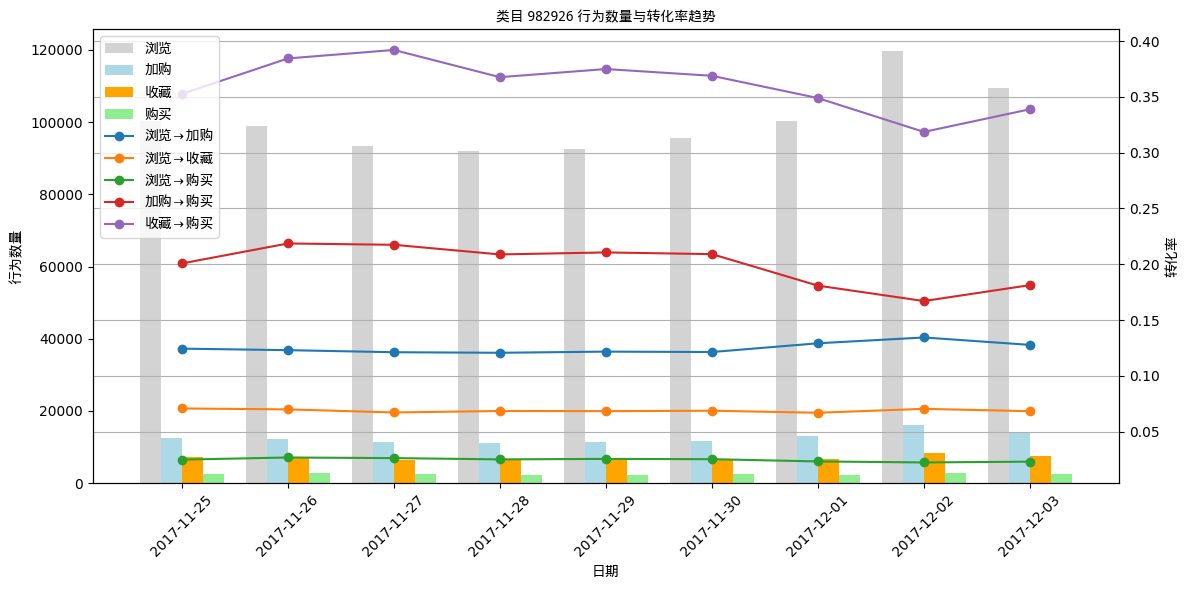

行为           date  category_id      浏览     加购    收藏    购买     浏览→加购     浏览→收藏  \
7608   2017-11-25      4145813   90315  12835  7751  3034  0.142114  0.085822   
17043  2017-11-26      4145813   91164  12791  7655  3331  0.140308  0.083970   
26478  2017-11-27      4145813   87850  11940  7160  3234  0.135913  0.081503   
35913  2017-11-28      4145813   87052  11996  7277  3038  0.137803  0.083594   
45348  2017-11-29      4145813   90272  12393  7663  3288  0.137285  0.084888   
54783  2017-11-30      4145813   92361  12861  7686  3242  0.139247  0.083217   
64218  2017-12-01      4145813   96634  14405  7883  3049  0.149068  0.081576   
73653  2017-12-02      4145813  115087  17444  9544  3692  0.151572  0.082929   
83088  2017-12-03      4145813  101321  14525  7998  3356  0.143356  0.078937   

行为        浏览→购买     加购→购买     收藏→购买  
7608   0.033594  0.236385  0.391433  
17043  0.036539  0.260417  0.435140  
26478  0.036813  0.270854  0.451676  
35913  0.034899  0.253251  0.417480  

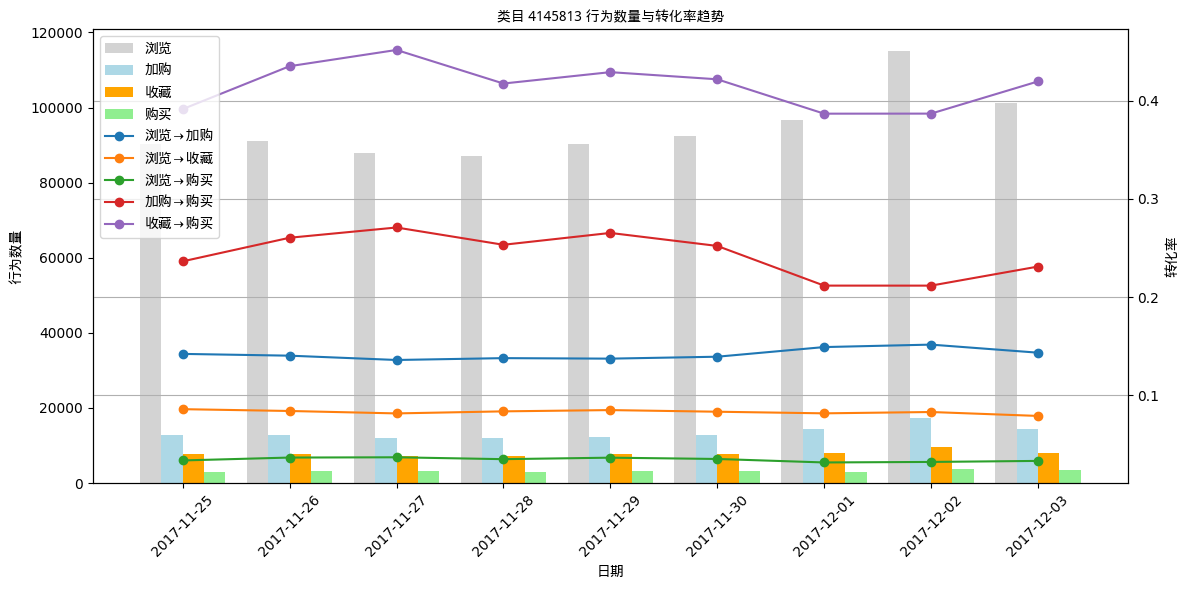

In [54]:

for cat in top_cats:
    cat_df = daily_cat_users[daily_cat_users['category_id'] == cat]
    dates = cat_df['date']
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # 绘制柱状图：行为数量
    width = 0.2  # 每组柱子的宽度
    x = range(len(dates))
    
    ax1.bar([i - 1.5 * width for i in x], cat_df['浏览'], width=width, label='浏览', color='lightgray')
    ax1.bar([i - 0.5 * width for i in x], cat_df['加购'], width=width, label='加购', color='lightblue')
    ax1.bar([i + 0.5 * width for i in x], cat_df['收藏'], width=width, label='收藏', color='orange')
    ax1.bar([i + 1.5 * width for i in x], cat_df['购买'], width=width, label='购买', color='lightgreen')

    ax1.set_xlabel('日期', fontproperties=myfont)
    ax1.set_ylabel('行为数量', fontproperties=myfont)
    ax1.set_xticks(x)
    ax1.set_xticklabels(dates, rotation=45)
    
    # 次坐标轴绘制折线图：转化率
    ax2 = ax1.twinx()
    for metric in ['浏览→加购', '浏览→收藏', '浏览→购买', '加购→购买', '收藏→购买']:
        ax2.plot(x, cat_df[metric], marker='o', label=metric)
    ax2.set_ylabel('转化率', fontproperties=myfont)

    # 图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', prop=myfont)
    
    plt.title(f'类目 {cat} 行为数量与转化率趋势', fontproperties=myfont)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'figures/类目_{cat}_行为与转化率趋势.png')
    plt.show()

类别一：category_id = 4756105
该类商品在各行为阶段的转化率表现中等偏稳定。

浏览转加购维持在 12.0% ~ 14.1% 之间，整体略有上升趋势，说明用户兴趣有逐步增强的迹象。

加购转购买基本维持在 17% ~ 19% 区间，波动不大，说明该类商品的加购行为较为真实，有一定成交意向。

收藏转购买则在 28% ~ 33% 区间浮动，表明收藏用户转化为购买的意愿较强。

浏览转购买维持在较低水平（约 2.2% ~ 2.6%），但随着促销日临近（12月初），略有增长。

总的来看，4756105 类商品的用户行为呈现出可预期、稳定性强的购买路径，适合作为平台的基础类目维持用户活跃与消费频率。

类别二：category_id = 982926
该类商品在整个周期内的转化效率偏低，但波动范围也较小。

浏览转加购始终在 10.6% ~ 11.5% 之间徘徊，是三类商品中最低的，显示出用户兴趣不高。

加购转购买在 14.9% ~ 17.1% 之间，说明加购后下单动力不强，可能受到价格、功能冗余等因素影响。

收藏转购买维持在 24% ~ 29% 区间，略低于其他类目，说明收藏更多是出于观望。

浏览转购买整体低于 2.2%，说明大多数用户只是浏览，并未产生明显的购买意图。

总体而言，982926 类商品的用户行为表现疲软，建议提升商品吸引力，如加强详情页优化、促销策略及用户个性化推荐，以改善整体转化路径。

类别三：category_id = 4145813
此类商品在所有行为路径的转化率中表现最为亮眼。

浏览转加购在 13.5% ~ 15.2%，整体呈上升趋势，显示出较强的商品吸引力。

加购转购买平均达到 21% ~ 27%，是三类中最高，说明用户一旦加购，往往具有明确购买意图。

收藏转购买甚至突破 40%，尤其是 12 月初，多日维持在 42%+ 的水平，表明收藏行为极具转化价值。

浏览转购买尽管仍不高（2.4% ~ 3.0%），但整体也略高于其他类别，显示其对用户有一定直接驱动力。

综合来看，4145813 属于高意向、高转化潜力类目，非常适合在大促节点（如双十二）中重点投放资源，引导用户从浏览向成交快速转化。

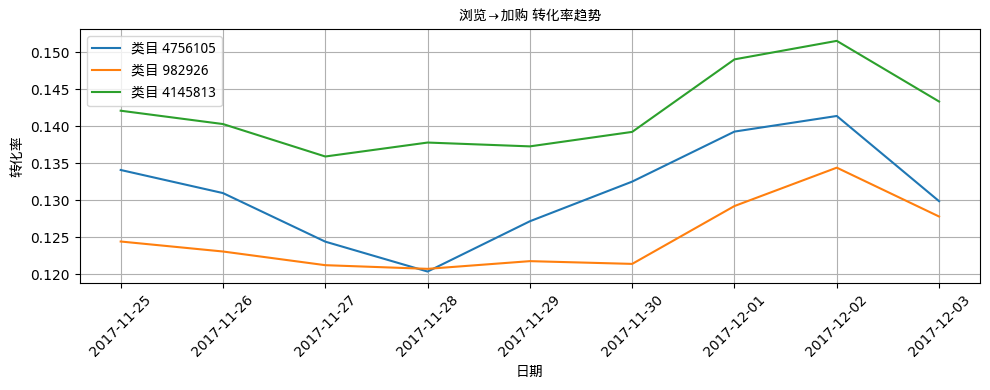

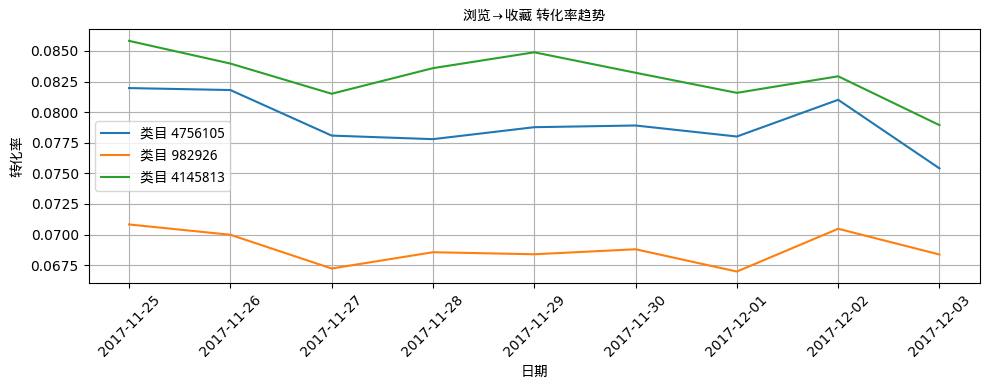

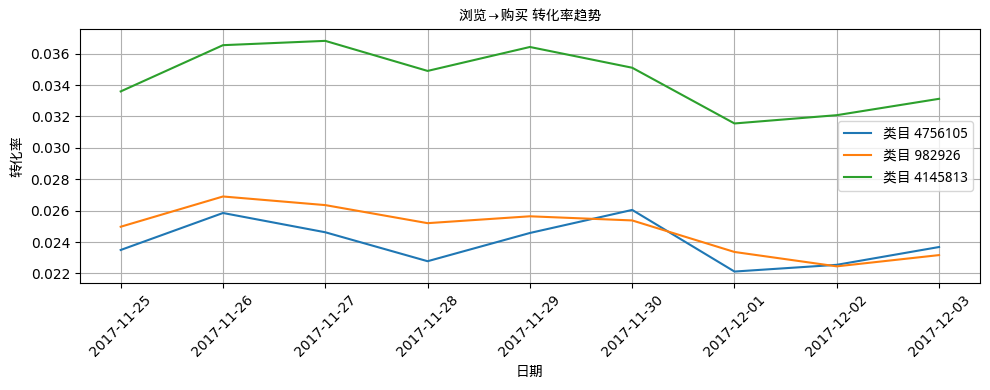

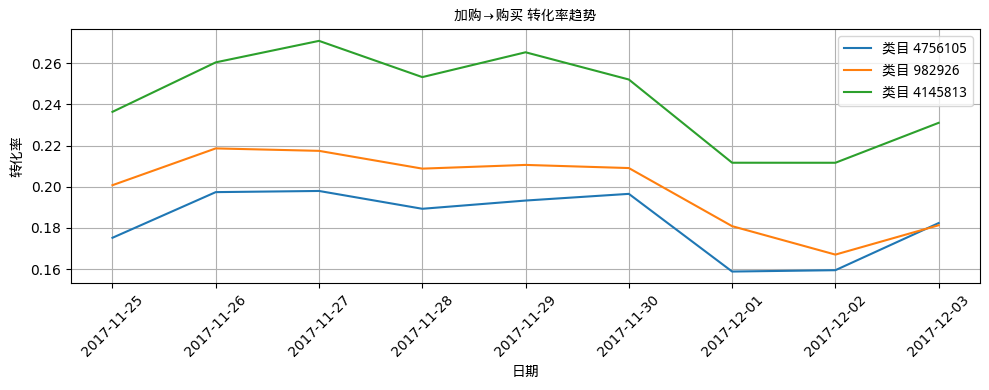

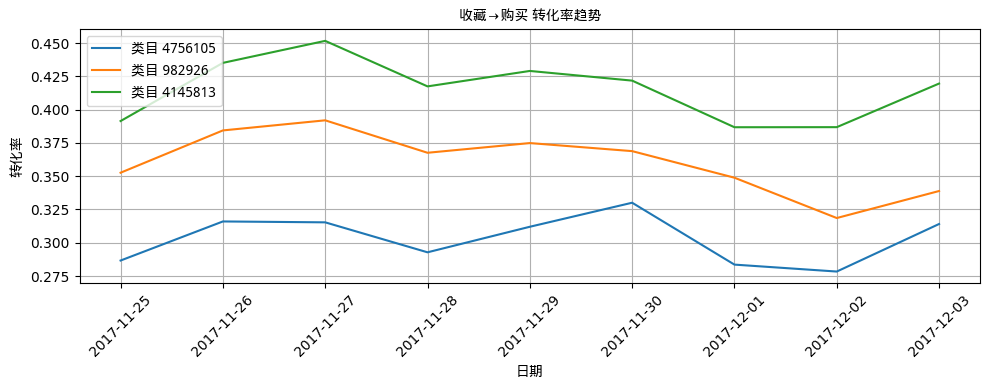

In [57]:
# 过滤数据并绘图
for metric in ['浏览→加购', '浏览→收藏', '浏览→购买', '加购→购买', '收藏→购买']:
    plt.figure(figsize=(10, 4))
    for cat in top_cats:
        cat_df = daily_cat_users[daily_cat_users['category_id'] == cat]
        
        plt.plot(cat_df['date'], cat_df[metric], label=f'类目 {cat}')
    plt.title(f'{metric} 转化率趋势',fontproperties=myfont)
    plt.xlabel('日期',fontproperties=myfont)
    plt.ylabel('转化率',fontproperties=myfont)
    plt.legend(prop=myfont)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'figures/{metric} 转化率趋势.png')
    plt.show()


在对比三类商品的转化路径时可以明显发现，4145813 类别在各项用户行为转化率上均表现最优。其浏览转加购、浏览转收藏、浏览转购买等基础路径转化率，均高于其他两个类别，说明用户对该类商品不仅感兴趣，而且更容易完成后续行为，尤其在加购到购买、收藏到购买这两个关键转化路径上，其平均转化率分别达到 24.4% 和 42.8%，显著高出 4756105 和 982926 类别。这表明 4145813 商品在促成交易方面的能力更强，可能得益于产品本身的吸引力、定价策略或促销效果。

从时间趋势来看，三类商品的“浏览转加购”转化率在整个分析区间内都呈现出较为一致的变化趋势。特别是在 12 月 1 日至 12 月 2 日 这一节点，所有类别的转化率均有所提升，尤其 4145813 类别的浏览转加购转化率从 11 月底的 13.7% 上升到 15.2%，显示出用户临近双十二活动时的购买兴趣正在集中释放。这一趋势侧面反映出节日营销活动对用户转化行为的积极影响。

而在分析转化率的波动性时，4145813 类别的行为路径波动最为明显，尤其在“加购→购买”路径上，存在接近 6% 的日波动范围。这说明该类商品的用户行为易受外部刺激变化影响，例如折扣、库存波动或商品更新。相反，4756105 类别的转化率最为平稳，用户对其行为更加稳定，可能为一些低风险、标准化程度高的商品，如生活必需品或快消类产品。

综合而言，4145813 是三者中最具潜力的商品类目，不仅用户在浏览后行为更活跃、转化链路更顺畅，而且在大促前期表现出更强的拉动能力，非常适合在活动期间重点推广和运营。而 982926 类别整体表现略显平淡，转化率偏低，说明用户的兴趣可能集中于浏览阶段但未能有效引导至加购和购买，建议加强该类商品的详情页优化、价格策略和用户激励机制。而 4756105 虽不突出但表现稳定，适合作为日常运营的基础类目，维持用户粘性并逐步提升转化效率。

## 2. 用户画像

In [38]:
#构建用户行为指标
#1、计算RFM指标
snapshot_date = df['datetime'].max() + pd.Timedelta(days=1)
rfm = df.groupby('user_id').agg({
    'datetime': lambda x: (snapshot_date - x.max()).days,  # Recency
    'user_id': 'count',                                    # Frequency (所有行为次数)
})

In [39]:
rfm = rfm.rename(columns={
    'datetime': 'Recency',
    'user_id': 'Frequency'
})

In [40]:
rfm

,Recency,Frequency
user_id,,
1,1,53
2,1,71
3,1,53
4,1,285
5,2,64
...,...,...
1018007,1,162
1018008,1,49
1018009,1,311


In [41]:
# 统计不同行为次数
behavior_counts = df.groupby(['user_id', 'behavior_type']).size().unstack(fill_value=0)
behavior_counts.columns = ['浏览次数', '加购次数', '收藏次数', '购买次数']


In [42]:
user_features = rfm.join(behavior_counts, how='left').fillna(0)

In [43]:
user_features

,Recency,Frequency,浏览次数,加购次数,收藏次数,购买次数
user_id,,,,,,
1,1,53,53,0,0,0
2,1,71,54,3,7,7
3,1,53,33,15,5,0
4,1,285,268,13,0,4
5,2,64,64,0,0,0
...,...,...,...,...,...,...
1018007,1,162,161,0,1,0
1018008,1,49,32,0,17,0
1018009,1,311,286,21,2,2


In [44]:
# 聚类分群
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# 数据标准化
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features)

# 转为带列名的 DataFrame
user_features_scaled = pd.DataFrame(user_features_scaled, 
                                    index=user_features.index, 
                                    columns=user_features.columns)

In [45]:
user_features_scaled

,Recency,Frequency,浏览次数,加购次数,收藏次数,购买次数
user_id,,,,,,
1,-0.256757,-0.547192,-0.460723,-0.735864,-0.379296,-0.736261
2,-0.256757,-0.338152,-0.448160,-0.336848,0.540296,1.810992
3,-0.256757,-0.547192,-0.711973,1.259213,0.277555,-0.736261
4,-0.256757,2.147101,2.240216,0.993202,-0.379296,0.719312
5,3.259037,-0.419445,-0.322535,-0.735864,-0.379296,-0.736261
...,...,...,...,...,...,...
1018007,-0.256757,0.718661,0.896028,-0.735864,-0.247926,-0.736261
1018008,-0.256757,-0.593645,-0.724535,-0.735864,1.853997,-0.736261
1018009,-0.256757,2.449048,2.466341,2.057243,-0.116555,-0.008474


In [46]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
user_features_scaled['cluster'] = kmeans.fit_predict(user_features_scaled)


In [47]:
user_features['cluster'] = user_features_scaled['cluster']
cluster_summary = user_features.groupby('cluster').mean()

In [48]:
cluster_summary

,Recency,Frequency,浏览次数,加购次数,收藏次数,购买次数
cluster,,,,,,
0,1.018383,233.614195,194.914974,5.598076,30.339907,2.761237
1,1.000000,63.981327,57.511064,3.388632,1.551001,1.530630
2,2.053017,59.557598,53.253692,3.373251,1.467711,1.462943
3,1.006189,218.069565,197.732182,14.155552,2.311969,3.869862


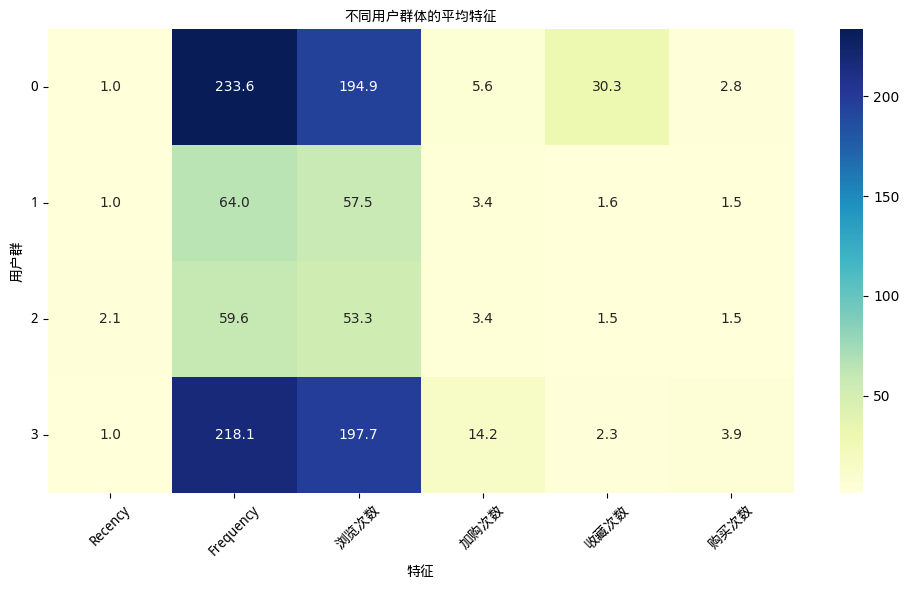

In [50]:
plt.figure(figsize=(10, 6))
ax = sns.heatmap(cluster_summary, annot=True, cmap='YlGnBu', fmt=".1f")

plt.title("不同用户群体的平均特征", fontproperties=myfont)
plt.xlabel("特征", fontproperties=myfont)
plt.ylabel("用户群", fontproperties=myfont)

# 设置 x 轴刻度字体
ax.set_xticklabels(ax.get_xticklabels(), fontproperties=myfont, rotation=45)

# 设置 y 轴刻度字体
ax.set_yticklabels(ax.get_yticklabels(), fontproperties=myfont, rotation=0)

plt.tight_layout()
plt.savefig(f'figures/不同用户群体的平均特征.png')
plt.show()

簇0：用户活跃且收藏多，但购买转化较低，适合重点培养促成转化。
簇3：用户高活跃高转化，是核心客户，建议重点维护。
簇1、簇2：低活跃用户，尤其簇2为沉睡用户，需通过营销活动唤醒或评估淘汰。
对核心客户（簇3）提供会员权益和个性化服务，提升忠诚度。
对潜在高价值用户（簇0）加强促销引导，提升收藏转化率。
对低活跃用户（簇1和簇2）实施激活策略，如优惠推送、提醒唤醒。